In [ ]:
##### <b>Step-1: Importing Libraries</b>

In [ ]:
import os, shutil, sys, cv2, time

import numpy as np
import pandas as pd
from skimage import transform
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
# from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as metrics

2024-05-05 12:56:09.679927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 12:56:09.680065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 12:56:09.795405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
np.random.seed(0)

##### <b>Step-2: Setting path for Testing, Training and validation directories</b>

In [ ]:
train_dir = './Train'
val_dir = './Validation'
test_dir = './Test'

for d in [train_dir, val_dir, test_dir]:
    try:
        os.mkdir(d)
    except FileExistsError:
        pass
    except:
        print('Error occurred.')

##### <b>Step-3: Setting path for classes</b>

In [ ]:
train_covid_dir = './Train/COVID'
train_normal_dir = './Train/Normal'

val_covid_dir = './Validation/COVID'
val_normal_dir = './Validation/Normal'

test_covid_dir = './Test/COVID'
test_normal_dir = './Test/Normal'


for d in [train_covid_dir, train_normal_dir, val_covid_dir, val_normal_dir, test_covid_dir, test_normal_dir]:
    try:
        os.mkdir(d)
    except FileExistsError:
        pass
    except:
        print('Error occurred.')

In [ ]:
# os.listdir(os.path.join(base, 'COVID'))

In [ ]:
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1  # 0.7, 0.15, 0.15

base = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset';
for d in os.listdir(base):
    if os.path.isdir(os.path.join(base, d)) and d not in ['Viral Pneumonia', 'Lung_Opacity']:
        files = os.listdir(os.path.join(base, d, 'images'))
        train_files = np.random.choice(files, int(train_ratio*len(files)), replace=False)
        val_files = np.random.choice(list(set(files) - set(train_files)), int(val_ratio*len(files)), replace=False)
        test_files = list(set(files) - set(train_files)- set(val_files))

        print(d, len(files))
        print('Train: {0:d},   Val: {1:d},   Test: {2:d}'.format(len(train_files), len(val_files), len(test_files)))
        for f, root in zip([train_files, val_files, test_files], [train_dir, val_dir, test_dir]):
            for file in tqdm(f, desc=root[2:]):
                try:
                    shutil.copy(os.path.join(base, d, 'images', file), os.path.join(root, d, file))
                except FileExistsError:
                    pass
                except:
                    print('Error occurred.')

Normal 10192
Train: 8153,   Val: 1019,   Test: 1020


Train:   0%|          | 0/8153 [00:00<?, ?it/s]

Validation:   0%|          | 0/1019 [00:00<?, ?it/s]

Test:   0%|          | 0/1020 [00:00<?, ?it/s]

COVID 3616
Train: 2892,   Val: 361,   Test: 363


Train:   0%|          | 0/2892 [00:00<?, ?it/s]

Validation:   0%|          | 0/361 [00:00<?, ?it/s]

Test:   0%|          | 0/363 [00:00<?, ?it/s]

##### <b>Step-4: Printing Total Images of each class</b>

In [ ]:
num_covid_train = len(os.listdir(train_covid_dir))
num_normal_train = len(os.listdir(train_normal_dir))

num_covid_validaition = len(os.listdir(val_covid_dir))
num_normal_validation= len(os.listdir(val_normal_dir))

num_covid_test = len(os.listdir(test_covid_dir))
num_normal_test= len(os.listdir(test_normal_dir))

print("Total Training COVID Images",num_covid_train)
print("Total Training NORMAL Images",num_normal_train)

print("-"*40)
print("Total validation COVID Images",num_covid_validaition)
print("Total validation NORMAL Images",num_normal_validation)

print("-"*40)
print("Total Test COVID Images", num_covid_test)
print("Total Test NORMAL Images",num_normal_test)

print("-"*100)
total_train = num_covid_train+num_normal_train
total_validation = num_covid_validaition+num_normal_validation
total_test = num_covid_test+num_normal_test
print("Total Training Images",total_train)
print("Total Validation Images",total_validation)
print("Total Testing Images",total_test)

Total Training COVID Images 2892
Total Training NORMAL Images 8153
----------------------------------------
Total validation COVID Images 361
Total validation NORMAL Images 1019
----------------------------------------
Total Test COVID Images 363
Total Test NORMAL Images 1020
----------------------------------------------------------------------------------------------------
Total Training Images 11045
Total Validation Images 1380
Total Testing Images 1383


##### <b>Step-5: Defining Image shape and batch size for Convolutional neural networks</b>

In [ ]:
IMG_SHAPE  = 150 # 224
batch_size = 32  # 50

##### <b>Step-6: Function for visualization of images</b>

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

##### <b>Step-7:Applying Data Augmentation on training data</b>

In [ ]:
image_gen_train = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, #10
                                     width_shift_range=0.1, #0.1
                                     height_shift_range=0.1, #0.1
                                     shear_range = 0.1, #0
                                     zoom_range = 0.1, #0.1
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle= True,
                                                     target_size = (IMG_SHAPE, IMG_SHAPE),
                                                    class_mode  = "categorical")

Found 11045 images belonging to 2 classes.


IF the image is 300x150 then will the target will tamper the data?

##### <b>Step-8: showing augmented images</b>

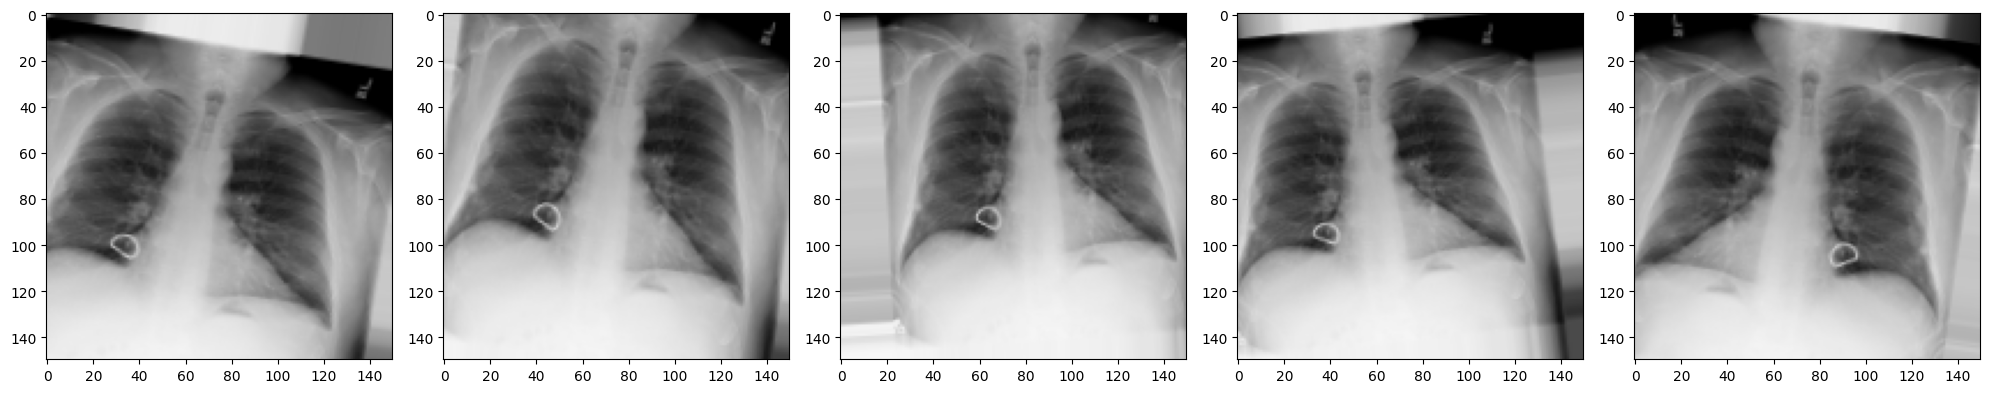

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(20)]  # Extract first image from each training batch
plotImages(augmented_images)  # Show first 5 images

##### <b>Step-9: Preprocessing of validation and testing data</b>

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(batch_size=50,
                                                 directory=test_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


##### <b>Step-10: building Convolutional Neural Networks</b>

In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
dropout_conv = 0.2
dropout_dense = 0.2

classifier = tf.keras.Sequential([
    tf.keras.layers.Conv2D(4, kernel_size, activation='relu', padding="same", input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size),

    tf.keras.layers.Conv2D(8, kernel_size, padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size),

    tf.keras.layers.Conv2D(16, kernel_size,padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size),

    tf.keras.layers.Conv2D(32, kernel_size, padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size),

#Fully conected
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation ="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(64, activation ="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(2, activation= "softmax")
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
classifier.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['acc', metrics.Precision(), metrics.Recall()])
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 4)    │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,514 (1.33 MB)

 Trainable params: 347,010 (1.32 MB)

 Non-trainable params: 504 (1.97 KB)

##### <b>Step-11: Training the Convolutional Neural Networks</b>

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=3, min_lr=0.0001)

In [ ]:
history = classifier.fit(train_data_gen,
                         steps_per_epoch=100, #28, #180
                         epochs = 5,#50, #200
                         validation_data=val_data_gen,
                         verbose = 1,)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/100 ━━━━━━━━━━━━━━━━━━━━ 25:29 15s/step - acc: 0.3750 - loss: 1.1099 - precision: 0.3750 - recall: 0.3750

I0000 00:00:1714913919.167184     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714913919.191495     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - acc: 0.6352 - loss: 0.8025 - precision: 0.6352 - recall: 0.6352

W0000 00:00:1714913944.202826     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 292ms/step - acc: 0.6357 - loss: 0.8011 - precision: 0.6357 - recall: 0.6357 - val_acc: 0.2616 - val_loss: 0.9132 - val_precision: 0.2616 - val_recall: 0.2616
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - acc: 0.7572 - loss: 0.5028 - precision: 0.7572 - recall: 0.7572 - val_acc: 0.2659 - val_loss: 1.1551 - val_precision: 0.2659 - val_recall: 0.2659
Epoch 3/5
 49/100 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - acc: 0.7932 - loss: 0.4677 - precision: 0.7932 - recall: 0.7932

W0000 00:00:1714913991.627648     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 319ms/step - acc: 0.8002 - loss: 0.4484 - precision: 0.8002 - recall: 0.8002 - val_acc: 0.3080 - val_loss: 1.0875 - val_precision: 0.3080 - val_recall: 0.3080
Epoch 4/5
 44/100 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - acc: 0.8230 - loss: 0.4120 - precision: 0.8230 - recall: 0.8230 

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - acc: 0.8240 - loss: 0.4045 - precision: 0.8240 - recall: 0.8240 - val_acc: 0.6638 - val_loss: 0.6474 - val_precision: 0.6638 - val_recall: 0.6638
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 270ms/step - acc: 0.8222 - loss: 0.4017 - precision: 0.8222 - recall: 0.8222 - val_acc: 0.6891 - val_loss: 0.5938 - val_precision: 0.6891 - val_recall: 0.6891


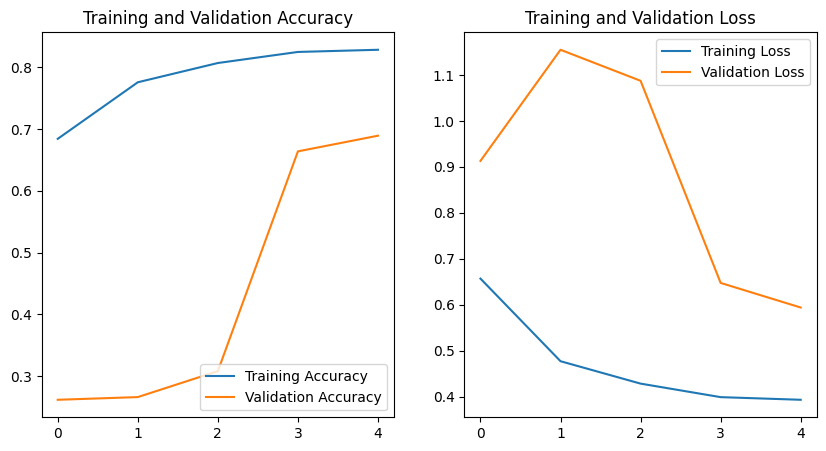

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('2_CNN_Accuracy_loss.png')
plt.savefig('2_CNN_Accuracy_loss.pdf', dpi=200)
plt.show()

In [ ]:
np.save('2_CNN_model_history.npy', history.history, allow_pickle=True)

##### <b>Step-12:Visualizing the training and validation using accuracy and loss in single graph </b>

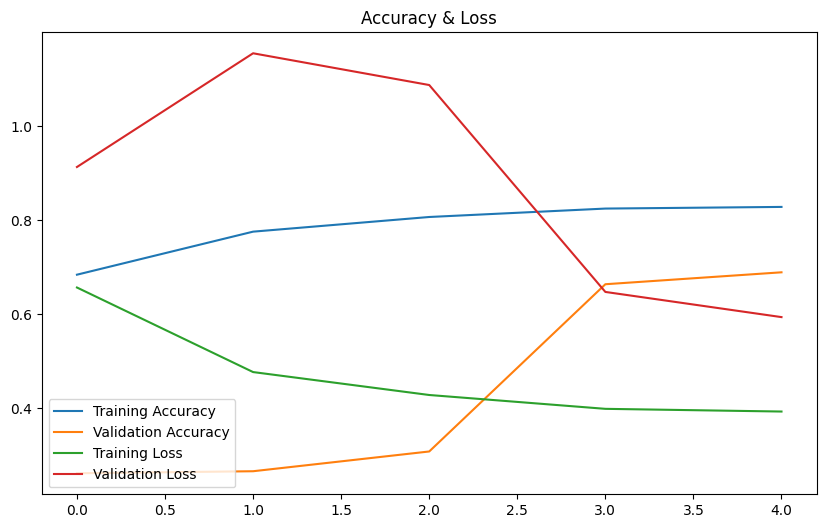

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Accuracy & Loss')
plt.show()

##### <b>Step-13:Saving model in json and h5 format</b>

In [ ]:
classifier.save('2_COVID_CNN.h5')

##### <b>Step-14: Testing Model on test data</b>

In [ ]:
classifier = tf.keras.models.load_model('./2_COVID_CNN.h5')

In [ ]:
results = classifier.evaluate(test_data_gen,batch_size=50)
print("test_loss, test accuracy",results)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 3/28 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - acc: 0.6844 - loss: 0.5697 - precision: 0.6844 - recall: 0.6844

W0000 00:00:1714914048.887928     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - acc: 0.7000 - loss: 0.5762 - precision: 0.7000 - recall: 0.7000
test_loss, test accuracy [0.5914767980575562, 0.6999276876449585, 0.6999276876449585, 0.6999276876449585]


W0000 00:00:1714914053.047080     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#####<b>Step-15:Testing</b>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The below image is  COVID-19  with  0.74  confidence


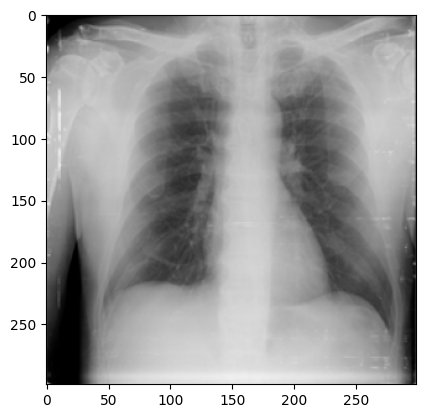

In [ ]:
image_1 = cv2.imread(os.path.join(test_covid_dir, os.listdir(test_covid_dir)[150]))
image = cv2.resize(image_1, (IMG_SHAPE, IMG_SHAPE))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = classifier.predict(image)
classes=np.argmax(predict,axis=1)
if classes==0:
    res = "COVID-19"
elif classes==1:
    res = "NORMAL"
confidence = str(round(max(predict[0]), 2))
plt.imshow(image_1)
print("The below image is ",res," with ",confidence," confidence")